<a href="https://colab.research.google.com/github/drwatson93/M2_A1/blob/main/M2_Assigment1_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This assignment is to learn the “End-to-end Machine Learning Pipeline”. The goal is to select
and train a regression model to predict the “average rating/vote” for each movie based on the
other relevant features. The data is taken from “The Movie Database (TMDb)” (attached) and
includes the info for around 5000 movies. You need to do the following:

1- Follow all the steps that we did for the housing data during the class (e.g., data load,
handling missing data, pre-processing, feature selection, model selections, cross
validation, and hyperparameter selection)

2- Perform exploratory data analysis to understand data

3- Handle missing data (if any) and explain the reason behind your strategy

4- Select the relevant features. Explain the reasons behind any feature elimination

5- Encode categorical values. Note that there are categorical features with more than one
value (e.g., genres). How do you represent them?

6- Create a Scikit-learn pipeline to do all pre-processing steps

7- Split data randomly. 80% training data and 20% test data (DONE)

8- Use 5-fold cross validation for model selection. Compare KNN Regression and Linear
regression. Use grid search to fine-tune the models (select hyperparameters)

9- Report and analyze the error (RMSE) on test data for the final selected model.

In [20]:
import numpy as np
import pandas as pd
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

import random
import time

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [66]:
# 1- Follow all the steps that we did for the housing data during the class 
# (e.g., data load, handling missing data, pre-processing, feature selection, model selections, cross validation, and hyperparameter selection)

# Data Load
tmdb_movies = pd.read_csv('https://raw.githubusercontent.com/drwatson93/M2_A1/main/tmdb_5000_movies.csv')
tmdb_movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [67]:
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [68]:
# Spliting data:
from sklearn.model_selection import train_test_split
tmdb_train_set, tmdb_test_set = train_test_split(tmdb_movies, test_size=0.2, random_state=RANDOM_STATE)

In [69]:
tmdb_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3842 entries, 4687 to 860
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                3842 non-null   int64  
 1   genres                3842 non-null   object 
 2   homepage              1381 non-null   object 
 3   id                    3842 non-null   int64  
 4   keywords              3842 non-null   object 
 5   original_language     3842 non-null   object 
 6   original_title        3842 non-null   object 
 7   overview              3840 non-null   object 
 8   popularity            3842 non-null   float64
 9   production_companies  3842 non-null   object 
 10  production_countries  3842 non-null   object 
 11  release_date          3842 non-null   object 
 12  revenue               3842 non-null   int64  
 13  runtime               3841 non-null   float64
 14  spoken_languages      3842 non-null   object 
 15  status             

In [70]:
# Dropping irrelevent columns as they are either string with no correlation, or would be irrelevent if converted to a numerical value.
columns = ['homepage', 'keywords', 'original_language', 'overview', 'production_companies', 'production_countries', 'production_countries', 'spoken_languages', 'tagline', ]

tmdb_train_set.drop(columns, axis=1, inplace=True)
tmdb_test_set.drop(columns, axis=1, inplace=True)

In [71]:
print('-'*30, '\n', tmdb_train_set.isnull().sum())
print('-'*30, '\n', tmdb_test_set.isnull().sum())

------------------------------ 
 budget            0
genres            0
id                0
original_title    0
popularity        0
release_date      0
revenue           0
runtime           1
status            0
title             0
vote_average      0
vote_count        0
dtype: int64
------------------------------ 
 budget            0
genres            0
id                0
original_title    0
popularity        0
release_date      1
revenue           0
runtime           1
status            0
title             0
vote_average      0
vote_count        0
dtype: int64


In [72]:
# Replacing missing values for both train and test sets.
# I can't understand what it means, but there are some 0 values of runtime column. So, fill the missing values of runtime column with 0.
tmdb_train_set['runtime'] = tmdb_train_set['runtime'].fillna(0)
tmdb_test_set['runtime']  = tmdb_test_set['runtime'].fillna(0)

# release_date column has one missing value in the test dataset. Fill it with the mostly used value.
tmdb_test_set.loc[tmdb_test_set['release_date'].isnull(), 'release_date'] = tmdb_test_set['release_date'].mode()[0]

In [73]:
# We need to convert the JSON format in the genres column to seperate columns in the data.
# Get all unique genres from the genres column
genres_tmdb_train_set = set(tmdb_train_set.genres.apply(lambda g: [d['name'] for d in json.loads(g)]).sum())
genres_tmdb_test_set = set(tmdb_test_set.genres.apply(lambda g: [d['name'] for d in json.loads(g)]).sum())

# For each unique genre, create a new boolean column
for genre in genres_tmdb_train_set:
    tmdb_train_set[genre] = tmdb_train_set.genres.apply(lambda s: genre in s)

for genre in genres_tmdb_test_set:
    tmdb_test_set[genre] = tmdb_test_set.genres.apply(lambda s: genre in s)    

tmdb_train_set.iloc[::,12:32] = tmdb_train_set.iloc[::,12:32].astype(int)
tmdb_test_set.iloc[::,12:32] = tmdb_test_set.iloc[::,12:32].astype(int)

In [74]:
tmdb_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 961 entries, 596 to 402
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   budget           961 non-null    int64  
 1   genres           961 non-null    object 
 2   id               961 non-null    int64  
 3   original_title   961 non-null    object 
 4   popularity       961 non-null    float64
 5   release_date     961 non-null    object 
 6   revenue          961 non-null    int64  
 7   runtime          961 non-null    float64
 8   status           961 non-null    object 
 9   title            961 non-null    object 
 10  vote_average     961 non-null    float64
 11  vote_count       961 non-null    int64  
 12  Romance          961 non-null    int64  
 13  Science Fiction  961 non-null    int64  
 14  Drama            961 non-null    int64  
 15  Crime            961 non-null    int64  
 16  Thriller         961 non-null    int64  
 17  Music         

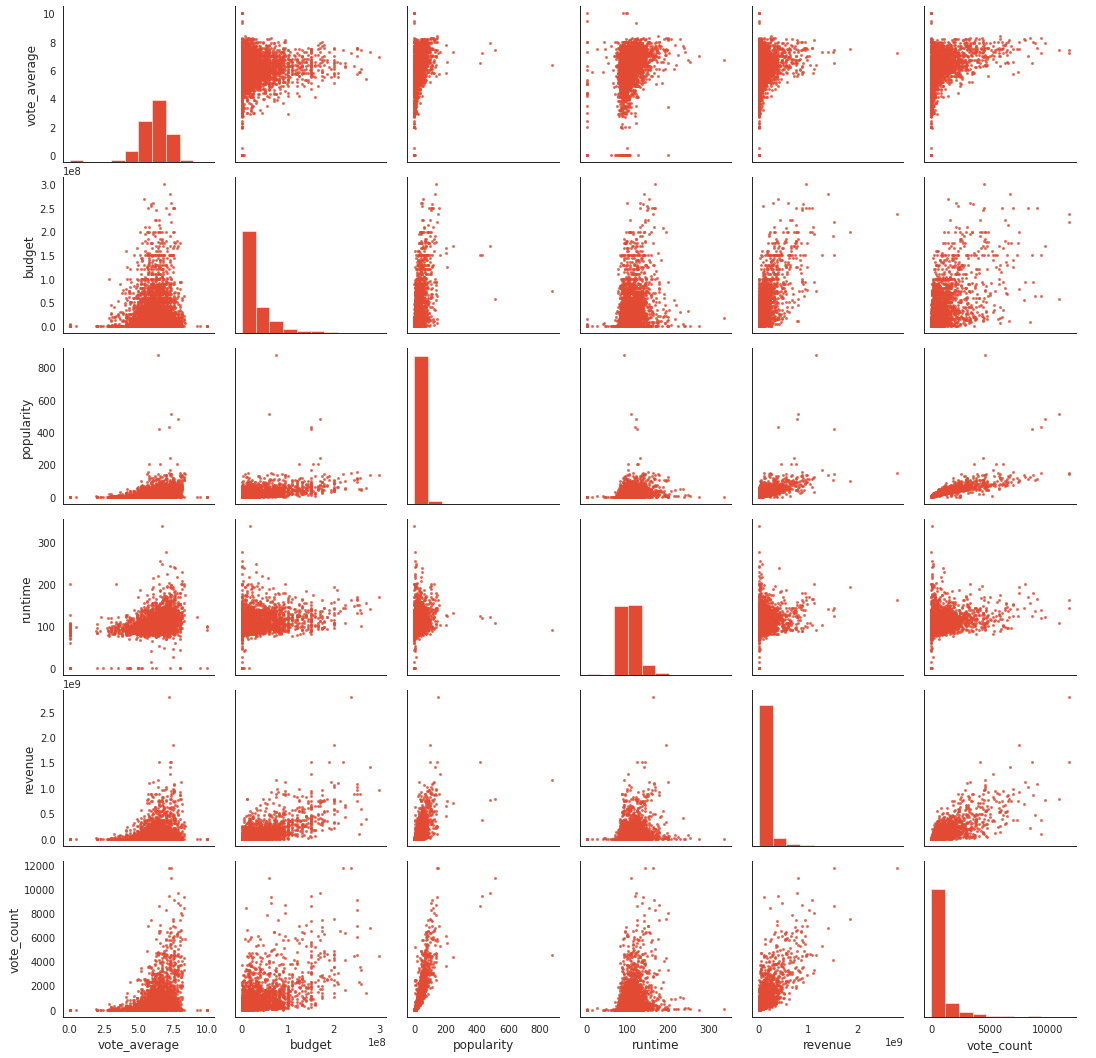

In [75]:
numerical_data = tmdb_train_set[['vote_average', 'budget', 'popularity', 'runtime', 'revenue', 'vote_count']]
g = sns.PairGrid(numerical_data)
g = g.map_diag(plt.hist, bins=10)
g = g.map_offdiag(plt.scatter, s=5, alpha=.9, linewidth=.5)
g = g.add_legend()
plt.show()

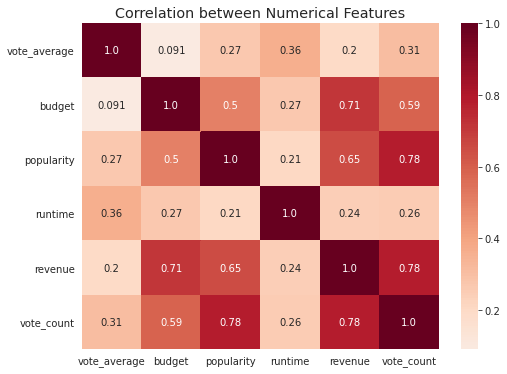

In [76]:
plt.figure(figsize=(8,6))
sns.heatmap(numerical_data.corr(), annot=True, fmt='.2', center=0.0, cmap='RdBu_r')
plt.title('Correlation between Numerical Features')
plt.show()

### **Added a feature due to low correlation.**
We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes. So, I'll be using IMDB's weighted rating (wr) which is given as :-

<img src='https://raw.githubusercontent.com/drwatson93/M2_A1/main/wr.png' />
<figcaption></figcaption></center>
</figure>

where,

v is the number of votes for the movie;

m is the minimum votes required to be listed in the chart;

R is the average rating of the movie; And

C is the mean vote across the whole report

In [80]:
C= tmdb_train_set['vote_average'].mean()
m= tmdb_train_set['vote_count'].quantile(0.9)

def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

tmdb_train_set['score'] = tmdb_train_set.apply(weighted_rating, axis=1).round(1)
tmdb_train_set[['vote_count', 'vote_average', 'score']].head(10)

,vote_count,vote_average,score
4687,34,6.1,6.1
2951,834,7.2,6.4
4071,760,6.9,6.3
4579,1708,7.8,6.9
2197,671,6.2,6.1
2321,249,6.2,6.1
4289,13,4.1,6.1
650,1234,7.1,6.5
2307,638,7.3,6.4
708,3040,6.4,6.3


In [79]:
C= tmdb_test_set['vote_average'].mean()
m= tmdb_test_set['vote_count'].quantile(0.9)

tmdb_test_set['score'] = tmdb_test_set.apply(weighted_rating, axis=1).round(1)
tmdb_test_set[['vote_count', 'vote_average', 'score']].head(10)

,vote_count,vote_average,score
596,269,5.2,6.0
3372,63,5.7,6.1
2702,68,5.5,6.1
2473,1020,6.7,6.3
8,5293,7.4,7.1
577,1217,5.5,5.9
3172,60,6.7,6.1
811,1698,6.6,6.3
2077,189,6.7,6.2
4032,40,6.0,6.1


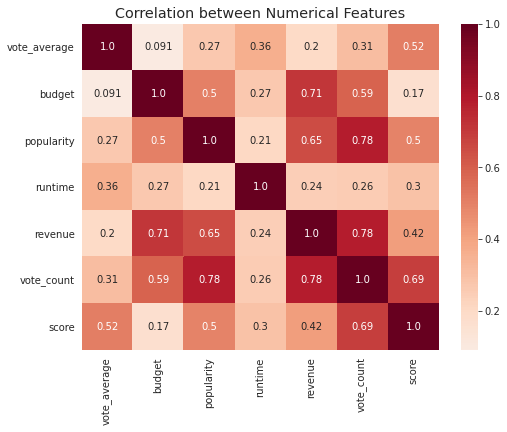

In [81]:
numerical_data = tmdb_train_set[['vote_average', 'budget', 'popularity', 'runtime', 'revenue', 'vote_count', 'score']]

plt.figure(figsize=(8,6))
sns.heatmap(numerical_data.corr(), annot=True, fmt='.2', center=0.0, cmap='RdBu_r')
plt.title('Correlation between Numerical Features')
plt.show()

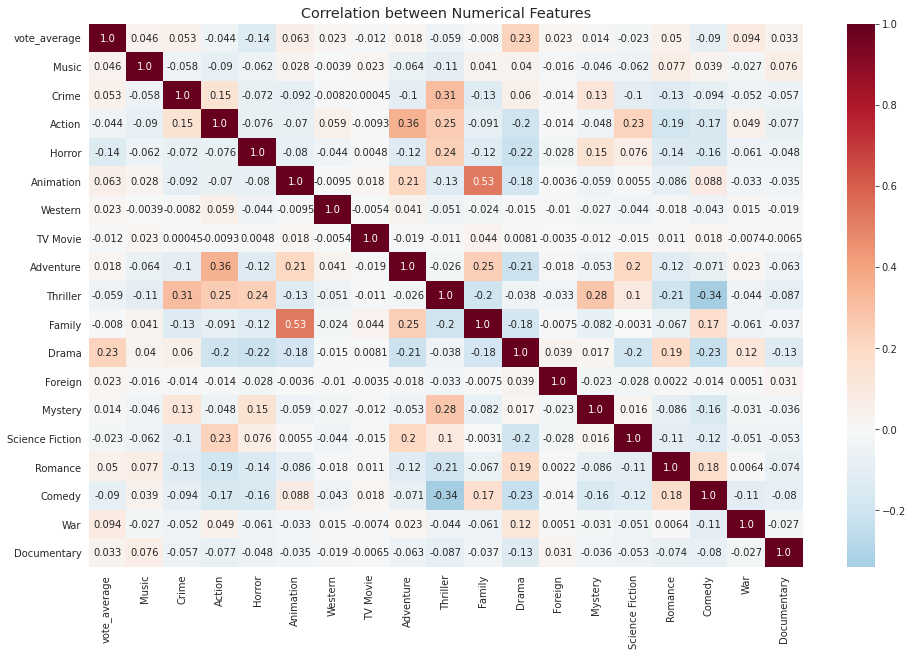

In [83]:
genre_data = tmdb_train_set[['vote_average', 'Music', 'Crime', 'Action', 'Horror', 'Animation', 'Western', 'TV Movie', 'Adventure', 'Thriller', 'Family', 'Drama', 'Foreign', 'Mystery', 
              'Science Fiction', 'Romance', 'Comedy', 'War', 'Documentary']]

plt.figure(figsize=(16,10))
sns.heatmap(genre_data.corr(), annot=True, fmt='.2', center=0.0, cmap='RdBu_r')
plt.title('Correlation between Numerical Features')
plt.show()

Feature Selectrion
Summary of intuitive nalysis


*   **Socre, Runtime, Vote_count, Popularity, Revenue** are great features for the model
*   The selected genres are **Music, Crime, Animation, Western, Adventure, Drama, Foreign, Mystery, Romance, War, Documentary** as these showed a postive correlation to Average Vote.



In [85]:
#manually_selected_features = ['runtime', 'vote_count', 'popularity', 'revenue', 'Music', 'Crime',
                              #'Animation', 'Western', 'Adventure', 'Drama', 'Foreign', 'Mystery', 'Romance', 'War', 'Documentary']

manually_selected_features = ['score', 'runtime', 'vote_count', 'popularity', 'revenue', 'Music', 'Crime', 
                              'Animation', 'Western', 'Adventure', 'Drama', 'Foreign', 'Mystery', 'Romance', 'War', 'Documentary']

In [86]:
tmdb_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3842 entries, 4687 to 860
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   budget           3842 non-null   int64  
 1   genres           3842 non-null   object 
 2   id               3842 non-null   int64  
 3   original_title   3842 non-null   object 
 4   popularity       3842 non-null   float64
 5   release_date     3842 non-null   object 
 6   revenue          3842 non-null   int64  
 7   runtime          3842 non-null   float64
 8   status           3842 non-null   object 
 9   title            3842 non-null   object 
 10  vote_average     3842 non-null   float64
 11  vote_count       3842 non-null   int64  
 12  Romance          3842 non-null   int64  
 13  Science Fiction  3842 non-null   int64  
 14  Crime            3842 non-null   int64  
 15  Drama            3842 non-null   int64  
 16  Thriller         3842 non-null   int64  
 17  Music       


100%|██████████| 10/10 [15:03<00:00, 90.38s/it]


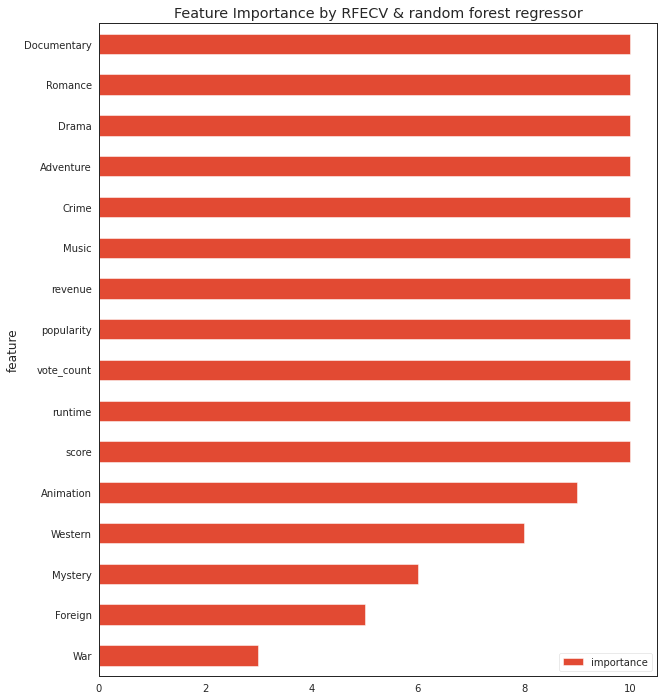

In [97]:
#features = tmdb_train_set.select_dtypes(include=['int64', 'float64', 'uint8', 'int8']).columns.tolist()
features = manually_selected_features
#features.remove('id')
#features.remove('vote_average')

X, Y = tmdb_train_set[features], tmdb_train_set['vote_average']

importances = np.zeros(len(features))

for i in tqdm(range(10)):
    model = RandomForestRegressor()
    rfecv = RFECV(model, cv=5)
    fit = rfecv.fit(X, Y)

    selected = np.array(fit.support_)
    importances = importances + selected

feature_df = pd.DataFrame({'feature': features, 'importance': importances})
feature_df.sort_values(by='importance', ascending=True, inplace=True)

feature_df.plot.barh(x='feature', y='importance', figsize=(10, 12))
plt.title('Feature Importance by RFECV & random forest regressor')    

features2 = feature_df.loc[feature_df.importance==10, 'feature'].tolist()

In [98]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
fit = pca.fit(X)

# Percentage of variance explained by each of the selected components.
print(pca.explained_variance_ratio_)

[1.00000000e+00 2.01782607e-11 1.85259116e-14]


In [99]:
feature_df = pd.DataFrame({'feature': features, 'importance': abs( pca.components_[0])})
feature_df.sort_values(by='importance', ascending=False, inplace=True)

features3 = feature_df.feature[:20]
features3

4         revenue
2      vote_count
3      popularity
1         runtime
9       Adventure
0           score
10          Drama
7       Animation
13        Romance
6           Crime
15    Documentary
5           Music
12        Mystery
8         Western
11        Foreign
14            War
Name: feature, dtype: object

In [104]:
# creation of pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline_lr = Pipeline([('scalar1',StandardScaler()),
                     ('pca1',PCA(n_components=2)),
                     ('lr_classifier',LinearRegression())])

pipeline_knn = Pipeline([('scalar1',StandardScaler()),
                     ('pca2',PCA(n_components=2)),
                     ('knn_classifier',KNeighborsRegressor())])

In [105]:
pipelines = [pipeline_lr, pipeline_knn]

In [106]:
best_accuracy=0.0
best_classifier=0
best_pipeline=""

In [107]:
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Linear Regression', 1: 'K Neighbors Regressor'}

# Fit the pipelines
for pipe in pipelines:
	pipe.fit(tmdb_train_set[features], tmdb_train_set['vote_average'])

In [108]:
for i,model in enumerate(pipelines):
    print("{} Test Accuracy: {}".format(pipe_dict[i],model.score(tmdb_test_set[features],tmdb_test_set['vote_average'])))

Linear Regression Test Accuracy: 0.2679669937331196
K Neighbors Regressor Test Accuracy: 0.3146096292367899


In [109]:
for i,model in enumerate(pipelines):
    if model.score(tmdb_test_set[features],tmdb_test_set['vote_average'])>best_accuracy:
        best_accuracy=model.score(tmdb_test_set[features],tmdb_test_set['vote_average'])
        best_pipeline=model
        best_classifier=i
print('Classifier with best accuracy:{}'.format(pipe_dict[best_classifier]))

Classifier with best accuracy:K Neighbors Regressor


In [110]:
# Model Selection

tmdb_train_set['revenue'] = np.log1p(tmdb_train_set['revenue'])
tmdb_train_set['budget'] = np.log1p(tmdb_train_set['budget'])

tmdb_test_set['budget'] = np.log1p(tmdb_test_set['budget'])
tmdb_test_set['revenue'] = np.log1p(tmdb_test_set['revenue'])

X = tmdb_train_set[features]
y = tmdb_train_set['vote_average']

In [111]:
def select_model(X, Y):

    best_models = {}
    models = [
        {
            'name': 'LinearRegression',
            'estimator': LinearRegression(),
            'hyperparameters': {},
        },
        {
            'name': 'KNeighbors',
            'estimator': KNeighborsRegressor(),
            'hyperparameters':{
                'n_neighbors': range(3,50,3),
                'weights': ['distance', 'uniform'],
                'algorithm': ['auto'],
                'leaf_size': list(range(10,51,10)),
                }
        }  
    ]
    
    for model in tqdm(models):
        print('\n', '-'*20, '\n', model['name'])
        start = time.perf_counter()
        grid = GridSearchCV(model['estimator'], param_grid=model['hyperparameters'], cv=5, scoring = "explained_variance", verbose=False, n_jobs=-1)
        grid.fit(X, Y)
        best_models[model['name']] = {'score': grid.best_score_, 'params': grid.best_params_}
        run = time.perf_counter() - start
        print('accuracy: {}\n{} --{:.2f} seconds.'.format(str(grid.best_score_), str(grid.best_params_), run))
        
    return best_models

best = select_model(X, y)
best


  0%|          | 0/2 [00:00<?, ?it/s]


 -------------------- 
 LinearRegression



 50%|█████     | 1/2 [00:01<00:01,  1.08s/it]

accuracy: 0.3755206891171257
{} --1.08 seconds.

 -------------------- 
 KNeighbors



100%|██████████| 2/2 [00:14<00:00,  7.08s/it]

accuracy: 0.3272277544526142
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 24, 'weights': 'distance'} --13.06 seconds.


{'KNeighbors': {'params': {'algorithm': 'auto',
   'leaf_size': 10,
   'n_neighbors': 24,
   'weights': 'distance'},
  'score': 0.3272277544526142},
 'LinearRegression': {'params': {}, 'score': 0.3755206891171257}}

In [132]:
def get_accuracy(features):
    X, y = tmdb_train_set[features], tmdb_train_set['vote_average']
    
    model = LinearRegression()
    result = cross_validate(model, X, y, cv=10, scoring="explained_variance", verbose=False, n_jobs=-1)
    return np.mean(result['test_score'])

In [133]:
all_features = tmdb_train_set.select_dtypes(include=['int64', 'float64', 'uint8', 'int8']).columns.tolist()
all_features.remove('id')
all_features.remove('vote_average')

best_features = None
best_accuracy = 0

feature_candidates = [all_features, manually_selected_features]
for flist in feature_candidates:
    acc = get_accuracy(flist)
    if acc > best_accuracy:
        best_accuracy = acc
        best_features = flist
        
print('The best accuracy is', best_accuracy)
best_features

The best accuracy is 0.3752799607976833


['score',
 'runtime',
 'vote_count',
 'popularity',
 'revenue',
 'Music',
 'Crime',
 'Animation',
 'Western',
 'Adventure',
 'Drama',
 'Foreign',
 'Mystery',
 'Romance',
 'War',
 'Documentary']

In [134]:
model = LinearRegression()
model.fit(tmdb_train_set[best_features], tmdb_train_set['vote_average'])
tmdb_predict = model.predict(tmdb_test_set[best_features])

In [135]:
tmdb_predict

array([ 5.57761887,  5.38248021,  6.04258793,  6.57647817,  7.84136779,
        5.35446624,  5.91169859,  6.2439511 ,  6.41557166,  5.91388083,
        5.56535537,  6.57752922,  5.80536221,  8.42219282,  5.58520587,
        5.8353393 ,  5.69551358,  5.66719878,  6.31860682,  5.47695354,
        6.00296182,  6.23174782,  5.78424532,  7.31331276,  6.81674854,
        7.03673277,  5.03512169,  5.94371629,  6.18711495,  4.6748337 ,
        5.63842605,  6.36660793,  7.93400207,  6.19797183,  6.85398214,
        8.19357179,  5.68112647,  6.00516621,  6.48933475,  5.95013975,
        5.50257693,  7.7429805 ,  6.26658858,  5.92773792,  6.2718685 ,
        5.76538191,  6.83580829,  6.13754104,  5.40470387,  5.55647338,
        5.64201517,  5.68348464,  6.42241829,  4.87857522,  5.29294563,
        5.78872554,  7.60458164,  5.97053853,  5.79586651,  6.90841888,
        6.26423413,  6.28541709,  7.48755903,  5.31461028,  6.57639384,
        6.15078632,  6.00273091,  6.10143441,  5.74899491,  6.63

In [131]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(tmdb_test_set['vote_average'], tmdb_predict)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.9660152912749889